In [20]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline




from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torchsummary import summary

import copy

torch.manual_seed(0)

## Intro: problem statement and data  

Cancerous cells are not all the same. Although the end result is a cell that divides uncontrollably, the visual appearance of a cancer cell can differ greatly. For this project we want to create a algorithm that can accurately label a given image of a cell as cancerous or not to apply supervised learning to solve this problm.

In this project, we will be building an supervised algorithm that can label cancerous and non-cancerous cells based on given images.
The entire dataset is a whopping 7.76 gigabyte selection of cell images, each labeled as 0 and 1 for non-cancerous and cancerous respectively. 220025 images total.
Each image is 77.6 kilobytes.


# EDA

## Data Preparation and Exploration

We want to see the actual pictures, what a malignant tumor looks like, what a normal cell looks like, and the data split.

In [21]:
path2labels = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"
paths=path2labels
labels_df = pd.read_csv(path2labels)

In [22]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [23]:
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [24]:
labels_df.shape

(220025, 2)

In [25]:
labels_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [26]:
labels_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


The dataset contains 89117 images labled as 1 (malignant), around 40%. 

# Visualizations: Visual sampling of cancerous cells and histograms of the data split

## Labels of 0 are normal, 1 is canceerous

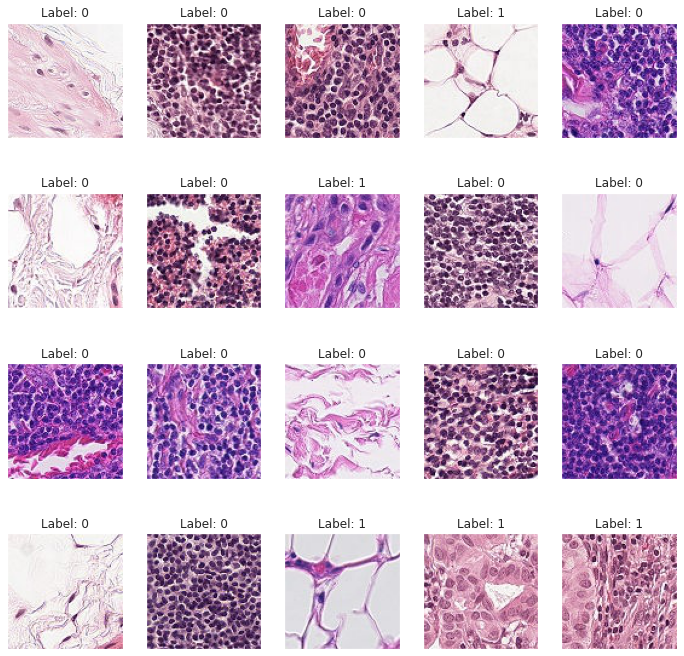

In [27]:
fig = plt.figure(figsize=(12, 12))
paths = "/kaggle/input/histopathologic-cancer-detection/train"
train_imgs = os.listdir(paths)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1)
    im = Image.open(paths + "/" + img)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    
    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {["1" if lab == 1 else "0"][0]}')

## Histogram to show data split

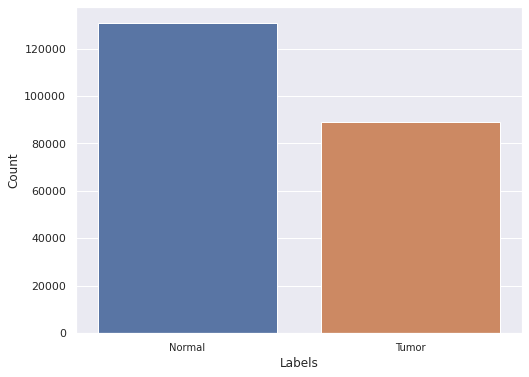

In [28]:
sns.set_theme()
plt.figure(figsize=(8, 6))
sns.countplot(data=labels_df, x='label')
plt.xticks(range(2), ['Normal', 'Tumor'], fontsize=10)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

### Since data does not seem to have any nulls and we assume in good faith that the source of data is accurately sourced, the data does not need any further pruning. 

# Data Preparation

In [29]:
class cancer_dataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # path to images
        path2data = os.path.join(data_dir, data_type)
        
        # list of images in directory
        filenames = os.listdir(path2data)
        
        # get full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # get labels
        path2labels = os.path.join(data_dir, "train_labels.csv")
        labels_df = pd.read_csv(path2labels)
        
        # seg dataframe index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from df
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        
        self.transform = transform
        
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        img = Image.open(self.full_filenames[idx]) # PIL image
        img = self.transform(img)
        return img, self.labels[idx]

### Transform to tensor and load into the device

In [30]:
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

In [31]:
data_dir = "/kaggle/input/histopathologic-cancer-detection"
img_dataset = cancer_dataset(data_dir, data_transformer, "train")

In [32]:
img, label = img_dataset[19]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 46, 46]) tensor(0.0505) tensor(1.)


# Splitting the Dataset
We will be splitting the dataset into train : validation (80:20)

In [33]:
len_dataset = len(img_dataset)
len_train = int(0.8 * len_dataset)
len_val = len_dataset - len_train

train_ds, val_ds = random_split(img_dataset, [len_train, len_val])

print(f'train dataset length: {len(train_ds)}')
print(f'validation dataset length: {len(val_ds)}')


train dataset length: 176020
validation dataset length: 44005


In [34]:
i = 0
for x, y in train_ds:
    print(x.shape, y)
    i += 1
    if i > 5:
        break

torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0


# Image Transformation
We will define some transformers for image augmentation

In [35]:
# transformer for trainging dataset
train_transf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor()
    ])

# No augmentation for validation dataset
val_transf = transforms.Compose([
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor()
    ])

# Overwrite the transforms functions
train_ds.transform = train_transf
val_ds.transform = val_transf

In [36]:
train_ds.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(96, 96), scale=(0.8, 1.0), ratio=(1.0, 1.0), interpolation=bilinear)
    ToTensor()
)

# Dataloaders
We create a dataloader with a *batch_size*

In [37]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)


# Creating the model

## Architecture: CNN model
This model consists of: 

    - Four CNN layers with pooling.
    - Two fully connected layers, with dropout
    - log_softmax activation layer
    
Convolutional Layers: These are the initial layers. They are designed to automatically and adaptively learn spatial hierarchies of features from the input images. They do this by performing a convolution operation on the input image, retaining the spatial relationship between pixels. The parameters you can adjust are the kernel size, stride, padding, and number of filters (which will determine the number of feature maps).

Pooling Layers: The pooling layers are responsible for reducing the spatial size (width and height) of the input volume. This serves to decrease the computational complexity for the upcoming layers and also provides a form of translation invariance.

Fully Connected Layers: These layers receive the flattened output from the last Convolutional layer (after all the spatial information has been processed) and performs higher-level reasoning. The first one is connected to the second fully connected layer which may output the final class scores in a classification problem.

Dropout: This is a regularization technique that prevents overfitting. During training, random nodes in the layer it's applied to will "drop out" or temporarily deactivate along with all its incoming and outgoing connections, which helps to make sure the network doesn't rely too heavily on any one node.

ReLU Activation Function: This is used after each Convolutional and Fully Connected layer (except for the last one) to introduce non-linearity into the model. This is important because most real world data is non-linear and we want our model to learn such patterns.

log_softmax Activation Function: This is used in the last layer as you have specified. It's commonly used when dealing with multi-class classification problems. It squashes the raw output of preceding layer into range between 0 and 1, which can be interpreted as probabilities of the classes. The logarithm of the output is usually used in combination with a negative log likelihood loss, which is a common setup for training such a network.

In [38]:
class Network(nn.Module):
    
    def __init__(self):
        
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.dropout_rate = 0.25
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1*1*64, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, X):
        
        x = self.pool(F.relu(self.conv1(X)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten
        x = x.view(-1, 1*1*64)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
# create instant of model
cnn_model = Network()

# define hardware
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)
print(device)

summary(cnn_model, input_size=(3, 46, 46), device=device.type)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
         MaxPool2d-2            [-1, 8, 22, 22]               0
            Conv2d-3           [-1, 16, 20, 20]           1,168
         MaxPool2d-4           [-1, 16, 10, 10]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          18,496
         MaxPool2d-8             [-1, 64, 1, 1]               0
            Linear-9                  [-1, 100]           6,500
           Linear-10                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.23
Params size (MB): 0.12
Estimate

In [39]:
m =torchvision.models.resnet50()
m.fc = nn.Linear(2048 , 2)
cnn_model = m

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)
print(device)

summary(cnn_model, input_size=(3, 46, 46), device=device.type)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 23, 23]           9,408
       BatchNorm2d-2           [-1, 64, 23, 23]             128
              ReLU-3           [-1, 64, 23, 23]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]           4,096
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]          16,384
      BatchNorm2d-12          [-1, 256, 12, 12]             512
           Conv2d-13          [-1, 256, 12, 12]          16,384
      BatchNorm2d-14          [-1,

# Loss function
We will use **NLLLoss** 

In [40]:
loss_func = nn.NLLLoss(reduction="sum")

# Optimizer
We will use **Adam**

In [41]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=0)

# Training Model

## Helper functions

In [42]:

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in tqdm(dataset_dl, leave=False):
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric


## Training function

In [43]:
from tqdm.notebook import trange, tqdm

def train_val(model, params, verbose=False):
    
    # Get parameters
    epochs = params["epochs"]
    opt = params["optimiser"]
    loss_func = params["f_loss"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # history of loss and metric values in each epoch
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}
    
    # a deep copy of weights for the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    best_loss = float('inf')      # init loss
    
    # Train loop
    for epoch in tqdm(range(epochs), leave=False):
        
        # get lr
        current_lr = get_lr(opt)
        if(verbose):
            print(f'Epoch {epoch +1}/{epochs}, current lr={current_lr}')
        
        # train model
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # save weights in a local file
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print("Saved best model weights")
            
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # lr schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights")
            model.load_state_dict(best_model_wts)
            
        if verbose:
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*20)
            
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history

## Train

In [ ]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 1,
 "optimiser": opt,
 "lr_change": lr_scheduler,
 "f_loss": loss_func,
 "weight_path": "weights.pt",
}

# Train model

model, loss_hist, metric_hist = train_val(model, params_train, verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1, current lr=0.0003


  0%|          | 0/5501 [00:00<?, ?it/s]

## Results and Analysis

## Loss & Metrics visual


In [ ]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')

# Inference
We will use our trained model to classify the test dataset

In [ ]:
class cancerdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
# load any model weights for the model
model.load_state_dict(torch.load('weights.pt'))

In [ ]:
path2sub = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"
labels_df = pd.read_csv(path2sub)
data_dir = '/kaggle/input/histopathologic-cancer-detection/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

img_dataset_test = cancerdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

In [ ]:
def inference(model,dataset,device,num_classes=2):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt           

y_test_out,_ = inference(model,img_dataset_test, device)  
y_test_pred=np.argmax(y_test_out,axis=1)

test_ids = [name.split('/')[-1].split('.')[0] for name in img_dataset_test.full_filenames]
test_preds = pd.DataFrame({"img": test_ids, "preds": y_test_pred})
submission = pd.merge(labels_df, test_preds, left_on='id', right_on='img')
submission = submission[['id', 'preds']]
submission.columns = ['id', 'label']
submission.head()


In [ ]:
submission.to_csv('submission.csv', index=False)